## **Importing libraries**

In [52]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from pathlib import Path

## Verifying the GPU Setup [tensorflow + CUDA (Compute Unified Device Architecture) => Let's you use GPU for Computation other than Graphics]

In [25]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

## **Data Preprocessing**
#### Used *'https://youtube.com/playlist?list=PLvz5lCwTgdXDNcXEVwwHsb9DwjNXZGsoy&si=gPCwVkKpS63FVLAC'* for guidance

# Training Image Preprocessing

In [26]:
curr_dir = os.getcwd()

In [27]:
training_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/train',
    labels="inferred", # leaving inferred, keras generates labels and class name automatically i.e.,
    # [Pepper_mold, Potato_healthy, Tomato_healthy, ...] alphabetically, where labels [0, 1, 2, ...]
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 24652 files belonging to 15 classes.


## Validation Image Preprocessing

In [28]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 5278 files belonging to 15 classes.


In [29]:
for x, y in training_set:
    print(x, x.shape)
    print(y, y.shape)
    break

tf.Tensor(
[[[[  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  [[  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  [[  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  ...

  [[  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [ 

# **Building Model**

In [30]:
mobile = MobileNet()

## Raw Testing on Pre-Build Model

In [31]:
curr_dir = os.getcwd()
curr_dir

'/home/root123/GitHub/Two_Months_ML_Journey/Week 4'

In [32]:
destination_path = 'test_data'
predict_img_path = curr_dir/Path(destination_path)

In [38]:
for img_file in predict_img_path.iterdir():
    if img_file.suffix.lower() in ['.jpg', '.png']:
        # Open image
        img = Image.open(img_file).convert('RGB').resize((224,224))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis = 0) # mobile net expects batches so adding a layer
        img_array_processed = preprocess_input(img_array)
        # Run through your pipeline (wrap in list or array)
        pred = mobile.predict(img_array_processed)
        decoded = decode_predictions(pred, top=3)[0]
        print(f'\nPredictions for {img_file.name}:')
        for cls_id, cls_name, score in decoded:
            print(f'{cls_name}:{score:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step

Predictions for pepper_bacterial_spot.JPG:
custard_apple:0.48
electric_ray:0.08
drum:0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Predictions for potato_early_blight.JPG:
African_chameleon:0.80
lacewing:0.05
chiton:0.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Predictions for tomato_target_spot.JPG:
pot:0.75
African_chameleon:0.07
custard_apple:0.04


### Tuning and Training Model

In [39]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [57]:
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)  # <-- this fixes the shape
x = Dense(1024, activation='relu')(x)
output = Dense(15, activation='softmax')(x)

In [58]:
model = Model(inputs = mobile.input, outputs = output)

In [59]:
for layer in model.layers[:-23]:
    layer.trainable = False # keeping only the last 23 models trainable

In [60]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,293,839 (16.38 MB)

 Trainable params: 2,927,631 (11.17 MB)

 Non-trainable params: 1,366,208 (5.21 MB)

In [61]:
model.compile(loss = 'categorical_crossentropy', metrics = [
    'accuracy',
    Precision(),
    Recall(),
])

In [71]:
training_history = model.fit(x=training_set, validation_data = validation_set, epochs = 20, verbose = 2)

Epoch 1/20
771/771 - 33s - 43ms/step - accuracy: 0.9890 - loss: 0.0410 - precision_1: 0.9892 - recall_1: 0.9889 - val_accuracy: 0.9416 - val_loss: 0.3322 - val_precision_1: 0.9432 - val_recall_1: 0.9411
Epoch 2/20
771/771 - 33s - 43ms/step - accuracy: 0.9897 - loss: 0.0341 - precision_1: 0.9901 - recall_1: 0.9895 - val_accuracy: 0.9248 - val_loss: 0.5010 - val_precision_1: 0.9268 - val_recall_1: 0.9231
Epoch 3/20
771/771 - 34s - 44ms/step - accuracy: 0.9916 - loss: 0.0305 - precision_1: 0.9918 - recall_1: 0.9914 - val_accuracy: 0.9180 - val_loss: 0.6640 - val_precision_1: 0.9205 - val_recall_1: 0.9172
Epoch 4/20
771/771 - 34s - 43ms/step - accuracy: 0.9923 - loss: 0.0289 - precision_1: 0.9925 - recall_1: 0.9922 - val_accuracy: 0.9163 - val_loss: 0.6407 - val_precision_1: 0.9178 - val_recall_1: 0.9159
Epoch 5/20
771/771 - 34s - 44ms/step - accuracy: 0.9921 - loss: 0.0305 - precision_1: 0.9922 - recall_1: 0.9920 - val_accuracy: 0.9375 - val_loss: 0.4234 - val_precision_1: 0.9390 - val_re

## Model Evaluation

In [72]:
train_loss, train_acc, train_pre, train_rec = model.evaluate(training_set)

771/771 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9982 - loss: 0.0062 - precision_1: 0.9982 - recall_1: 0.9982


In [73]:
print(train_loss, train_acc, train_pre, train_rec)

0.006193113513290882 0.9981746077537537 0.9982150793075562 0.9981746077537537


In [74]:
valid_loss, valid_acc, valid_pre, valid_rec = model.evaluate(validation_set)

165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9557 - loss: 0.3297 - precision_1: 0.9566 - recall_1: 0.9555


In [75]:
print(valid_loss, valid_acc, valid_pre, valid_rec)

0.32966408133506775 0.9556650519371033 0.9565629959106445 0.9554755687713623


## Accuracy Visualization

In [76]:
print(training_history.history['accuracy'])

[0.9890475273132324, 0.9896965622901917, 0.9916436672210693, 0.9922521710395813, 0.99213045835495, 0.9943209290504456, 0.9944426417350769, 0.994199275970459, 0.9946048855781555, 0.9951727986335754, 0.9942398071289062, 0.9957001209259033, 0.9961463809013367, 0.996227502822876, 0.9955784678459167, 0.9958218336105347, 0.9966331124305725, 0.9970793724060059, 0.9961057901382446, 0.9959840774536133]


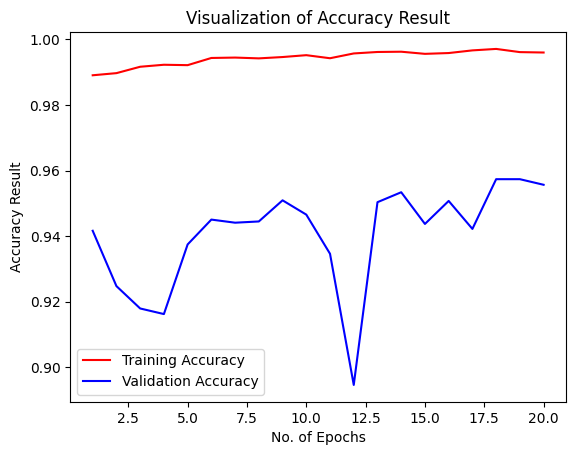

In [78]:
epochs = [i for i in range(1,21)]
plt.plot(epochs, training_history.history['accuracy'], color='red', label ='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label ='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Result')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

## Saving Model

In [79]:
model.save(f'{curr_dir}/saved_models/mobileNet_model.keras') # one extension of saving, not using h5 as keras takes less space

In [80]:
training_history.history

{'accuracy': [0.9890475273132324,
  0.9896965622901917,
  0.9916436672210693,
  0.9922521710395813,
  0.99213045835495,
  0.9943209290504456,
  0.9944426417350769,
  0.994199275970459,
  0.9946048855781555,
  0.9951727986335754,
  0.9942398071289062,
  0.9957001209259033,
  0.9961463809013367,
  0.996227502822876,
  0.9955784678459167,
  0.9958218336105347,
  0.9966331124305725,
  0.9970793724060059,
  0.9961057901382446,
  0.9959840774536133],
 'loss': [0.04101403057575226,
  0.03405499830842018,
  0.030506400391459465,
  0.028904864564538002,
  0.0305287167429924,
  0.02203941158950329,
  0.020902808755636215,
  0.02226070687174797,
  0.02152974344789982,
  0.017868980765342712,
  0.02250666171312332,
  0.015396674163639545,
  0.014917789027094841,
  0.015366710722446442,
  0.016495659947395325,
  0.016589399427175522,
  0.01313028670847416,
  0.011650160886347294,
  0.01544088777154684,
  0.01746649108827114],
 'precision_1': [0.9892067313194275,
  0.9900965690612793,
  0.9918029308

In [81]:
# storing history in json format
import json
with open(f'{curr_dir}/training_history/mobileNet_training_hist.json', 'w') as f:
  json.dump(training_history.history, f)